# Filter data

We calculate colony growth rate of Staph-Pseudomonas co-cultures on agar-pads and perform some filtering steps

Note: SA1 is GFP strain / SA2 is RFP strain

In [36]:
#next two lines make sure that Matplotlib plots are shown properly in Jupyter Notebook
%matplotlib inline
#%matplotlib widget
%config InlineBackend.figure_format = 'retina'

#main data analysis packages
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#path handling
import pathlib

--- 

## Load data

In [37]:
#set path to output csv files
path_data_files = pathlib.Path("/Users/simonvanvliet/TempData/DataFiles/") 

#read data
csv_name = path_data_files / "all_data.csv"
df_all = pd.read_csv(csv_name, index_col=0)

#set settings
dt_frames = 3/60 #time between frames in hours 

---

## Pre-process data 

We do some clean up by:

- removing PA data from data frame, as we only care about SA growth. 
- removing untracked colonies
- remove colonies close to frame edge

We add some new fields to data frame:

- `unique_id`: a unique ID for each colony by combining strain with position number and with colony_id
- `log_norm_area`: to compare growth between colonies we first normalize colony area to 1 in the first frame and than take the log of this (colony grow exponentially in area)
- `genotype` : genotype of SA of strain
- `marker`: color marker of SA strain
- `media`: growth media of experiment 
- `community`: specifies combination of marker and genotype

We then plot the log normalized area as function of time.

In [38]:
def parse_conditon(x):

    SA1genotype = x['condition'].split('GFP')[0].split('_')[-1]
    SA2genotype = x['condition'].split('RFP')[0].split('_')[-1]
    
    
    media = x['condition'].split('_')[-1]
    
    d = {}
    d['media'] = media
    
    if "PA" in x['condition']:
        d['community'] = x.condition.split('_PA')[0]
        d['PA_present'] = True
    else:
        d['community'] = x.condition.split('_TSB')[0]+"_noPA"    
        d['PA_present'] = False
    if x['strain']=='SA1':
        d['genotype'] = SA1genotype
        d['marker'] = 'GFP'
    elif x['strain']=='SA2':
        d['genotype'] = SA2genotype
        d['marker'] = 'RFP'
    elif x['strain']=='PAO1':
        d['genotype'] = 'PAO1'
        d['marker'] = 'NA'
    else:
        d['genotype'] = 'NA'
        d['marker'] = 'NA'
        
    index = ['genotype', 'marker', 'media','community','PA_present']    
        
    return pd.Series(d, index=index)


#filter out PA and untracked colonies
df = df_all.loc[(~(df_all['strain']=='PA')) & (df_all['colony_id']>=0)].copy()

#add unique id
unique_id = df['strain'].map(str) + '-' + df['exp_name'].map(str) + '-' + df['pos'].map(str) + '-' + df['colony_id'].map(str)  
df['unique_id'] = unique_id

#add time in hours
df['time'] = df['frame']*dt_frames

# add normalized area
df['area'] = df['area'].astype(float)
df['lognorm_area'] = np.log(df['area'].div(df.groupby('unique_id')['area'].transform('first')))
df['log_area_change'] = df.groupby('unique_id')['lognorm_area'].diff(1)

#add parsed condition
df = pd.concat([df, df.apply(parse_conditon, axis=1)], axis=1)

#filter out data without PA
df = df.loc[df['PA_present']].copy()

In [39]:
df_all

,label,area,centroid-0,centroid-1,axis_major_length,axis_minor_length,frame,pos,strain,condition,exp_name,colony_id,min_dist_PA_centroid,min_dist_PA_edge2edge
0,1,847,80.007084,1266.676505,35.686648,31.488072,0,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,20230411,0,181.143088,148.929514
1,2,800,89.106250,1374.490000,44.041145,24.302579,0,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,20230411,1,224.914209,195.900485
2,3,820,102.460976,1552.109756,35.487305,30.556544,0,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,20230411,2,105.174274,79.025312
3,4,272,171.591912,1580.511029,24.463297,14.323920,0,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,20230411,3,88.577125,72.034714
4,5,1304,224.340491,1096.875000,59.563939,29.038293,0,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,20230411,4,130.699802,96.690227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374658,46,8730,1861.867125,2005.427950,139.978844,101.788784,79,23,PA,JE2GFP_gltTRFP_PAO1_TSB16h,20230427,-1,NaN,NaN
374659,47,5588,1874.336614,334.982820,172.063928,44.742684,79,23,PA,JE2GFP_gltTRFP_PAO1_TSB16h,20230427,-1,NaN,NaN
374660,48,13113,1884.974529,528.421948,160.562188,149.047933,79,23,PA,JE2GFP_gltTRFP_PAO1_TSB16h,20230427,-1,NaN,NaN
374661,49,2504,1934.647364,1842.033546,97.441708,45.202213,79,23,PA,JE2GFP_gltTRFP_PAO1_TSB16h,20230427,-1,NaN,NaN


---

## Filter Data 

### Filter out miss-tracked colonies

We see there are some weird trajectories which we need to remove.

We do automatic filtering by calculate the log length change between two frames and cutting trajectories when this becomes too big or small

count    193829.000000
mean          0.029388
std           0.039851
min          -1.240078
25%           0.010344
50%           0.024898
75%           0.045126
max           0.920205
Name: log_area_change, dtype: float64
[-0.03638331  0.17285544]


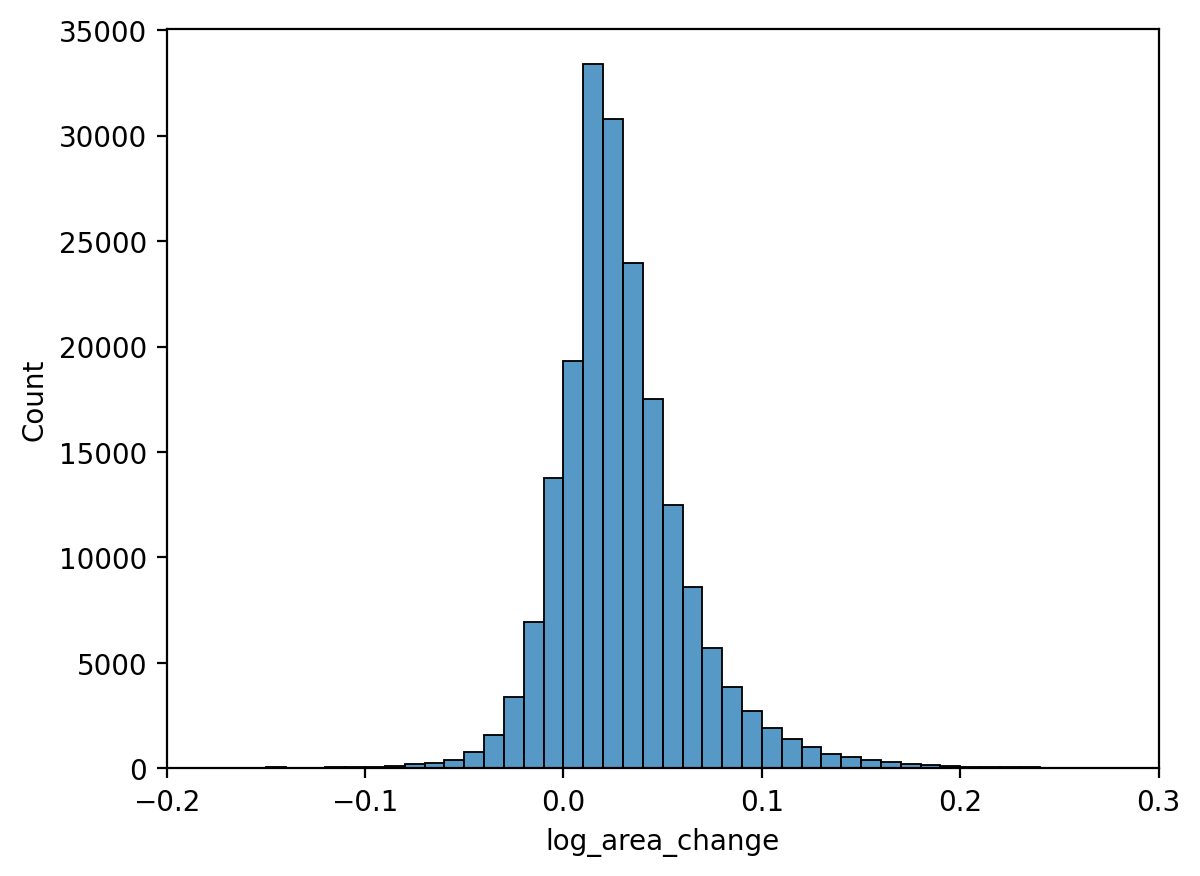

In [40]:
sns.histplot(data=df, x='log_area_change', bins=np.arange(-0.2,0.3,0.01)).set_xlim(-0.2,0.3)
print(df['log_area_change'].describe())
print(np.nanquantile(df['log_area_change'],[0.015,0.995]))

Based on histogram we can set max change in length (corresponds to max growth rate) and plot the resulting filtered data

In [41]:
#set min and max change in log area between frames for filtering
min_dl = -0.06
max_dl = 0.18

#stop tracks at first frame where error occurs
df['track_error'] = (df['log_area_change']<min_dl) | (df['log_area_change']>max_dl)
track_filter = df.groupby('unique_id')['track_error'].cumsum() > 0
df_filtered = df.loc[~track_filter].copy()

### Filter out colonies close to edge

In [42]:
d_to_edge = 300
imW = 2048
imH = 2044

centre_filter = (df_filtered['centroid-0']>d_to_edge) & (df_filtered['centroid-0']<imH-d_to_edge) & (df_filtered['centroid-1']>d_to_edge) & (df_filtered['centroid-1']<imH-d_to_edge)

df_filtered = df_filtered.loc[centre_filter].copy()

In [43]:
#save filtered data to file
df_filtered.to_csv(path_data_files / "all_data_filtered.csv")

## Check number of colonies

Let's check how many colonies we can track as function of time:

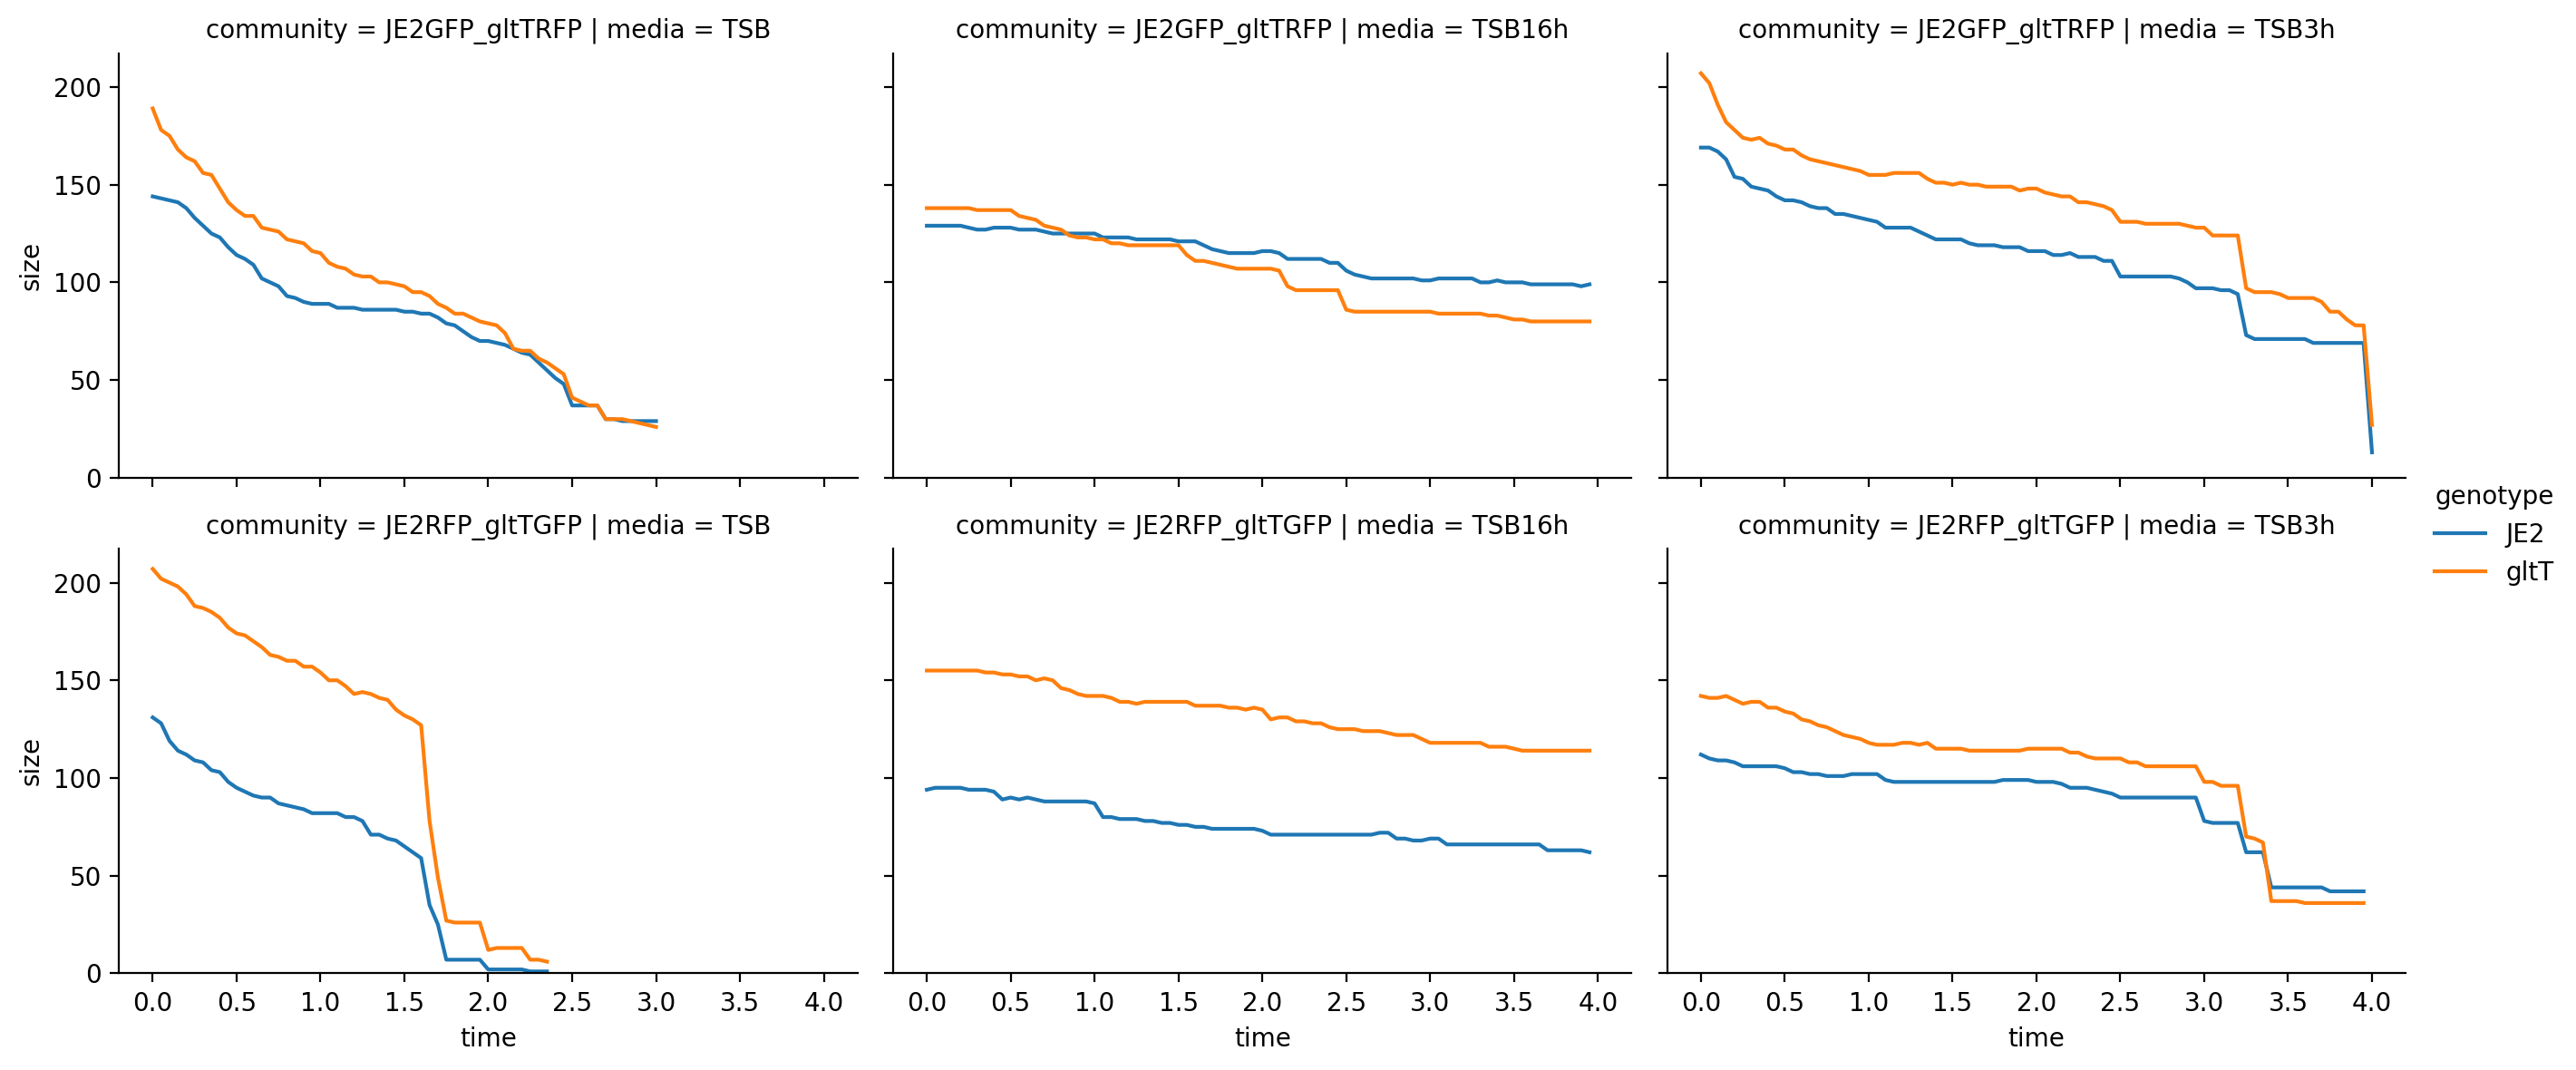

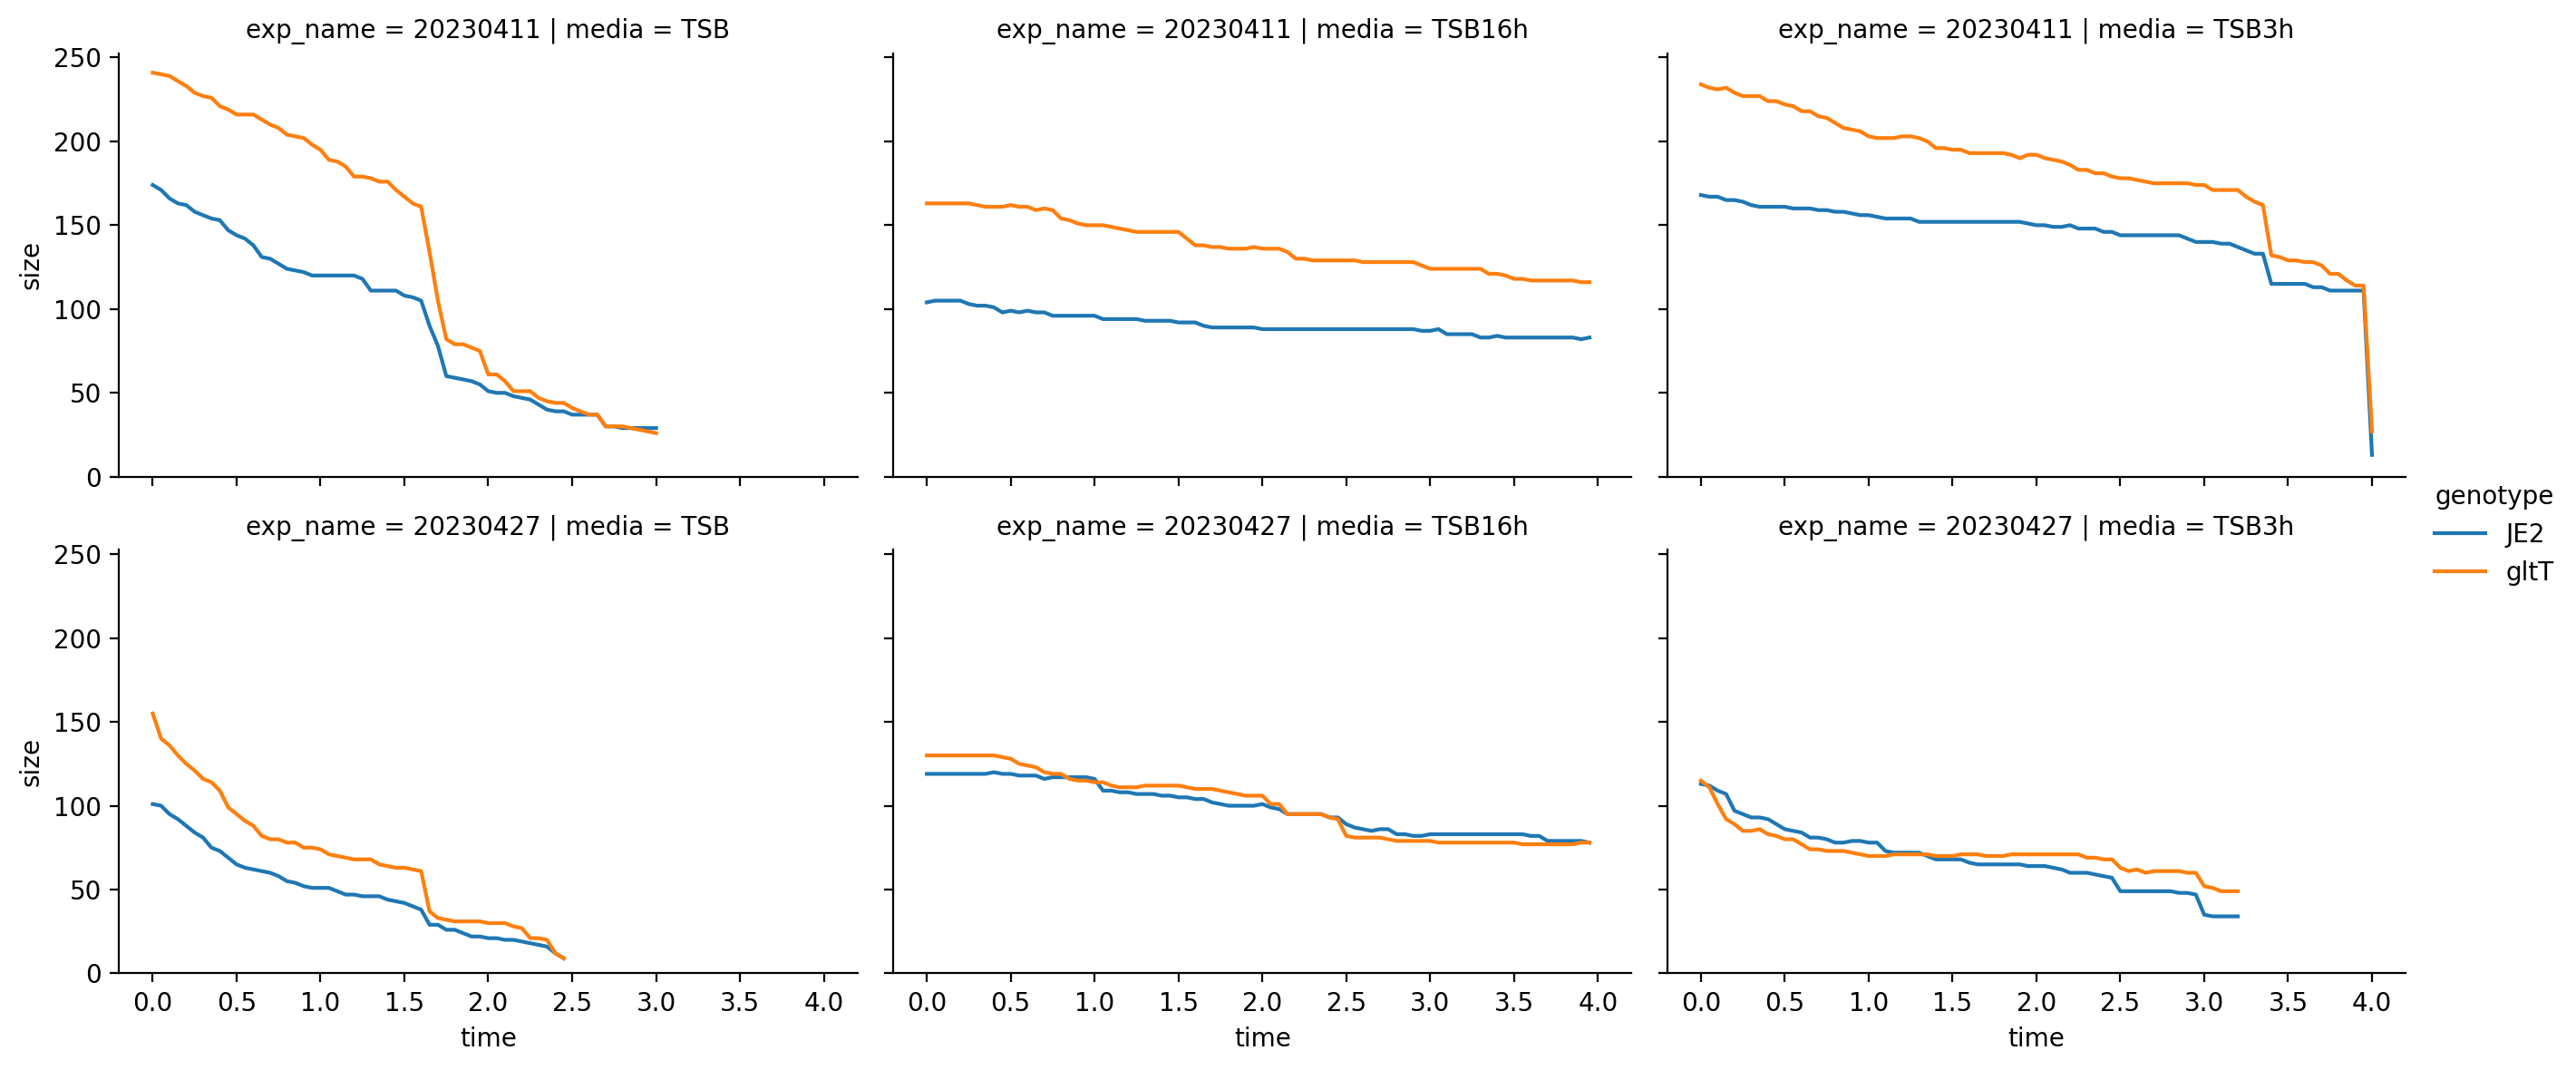

In [44]:
col_num_t = df_filtered.groupby(['community','media','genotype','frame','time'], as_index=False).size()
g = sns.FacetGrid(data=col_num_t, row='community',col='media',hue='genotype',aspect=1.5)
g.map_dataframe(sns.lineplot, x='time', y='size').add_legend()
g.set(ylim=(0, None))

col_num_t = df_filtered.groupby(['exp_name','media','genotype','frame','time'], as_index=False).size()
g = sns.FacetGrid(data=col_num_t, row='exp_name',col='media',hue='genotype',aspect=1.5)
g.map_dataframe(sns.lineplot, x='time', y='size').add_legend()
g.set(ylim=(0, None))